In [1]:
import pandas as pd
import numpy as np
import joblib

import warnings

warnings.filterwarnings("ignore")

from afl_match_outcome_model.config import match_summary_file_path, player_stats_file_path, odds_file_path, venue_file_path, team_file_path

from afl_match_outcome_model.data_preparation.odds import convert_odds_team_opp
from afl_match_outcome_model.data_preparation.preprocessing import convert_home_away_to_team_opp_data
from afl_match_outcome_model.data_preparation.elo import create_elo_ratings_home_away

from sklearn.model_selection import train_test_split

import geopy.distance
import re

import matplotlib.pyplot as plt
import tensorflow as tf
# tf.compat.v1.disable_v2_behavior()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tftf.compat.v1.disable_v2_behavior()

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-01-23 21:24:35.589966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load Data

In [2]:
odds = pd.read_csv(odds_file_path)
odds = convert_odds_team_opp(odds)

In [3]:
venue_info = pd.read_csv(venue_file_path)

In [4]:
team_info = pd.read_csv(team_file_path).rename(columns = {'Home_Ground_1':'Team_Home_Venue'})
opp_info = team_info.copy().rename(columns={'Team':'Opponent', 'Team_Home_Venue':'Opp_Home_Venue'})

In [5]:
matches = pd.read_csv(match_summary_file_path)
matches = matches.sort_values(by = ['Date']).reset_index(drop = True)
matches = matches[matches['Year'] > 2011]
matches = create_elo_ratings_home_away(matches, 32)
matches = convert_home_away_to_team_opp_data(matches)
matches['Opp_Result'] = np.where(matches['Result'] == 0, 1, 0)
matches['Opp_Margin'] = -1*matches['Margin']
matches.head()

,Team,Opponent,Q4_Score,Margin,Total Game Score,Venue,City,Date,Temperature,Year,Round_ID,Match_ID,Team_ELO,Opp_ELO,ELO_diff,ELO_abs_diff,Team_ELO_Probs,Opp_ELO_Probs,ELO_probs_diff,ELO_probs_abs_diff,Home,Result,Opp_Result,Opp_Margin
0,Fremantle,Geelong,16.9.105 - 15.11.101,4,206,Subiaco,Perth,2012-03-31 19:45:00,24.0,2012,201201,201201_Fremantle_Geelong,1500.0,1500.0,0.0,0.0,0.5,0.5,0.0,0.0,1,1,0,-4
1,Geelong,Fremantle,16.9.105 - 15.11.101,-4,206,Subiaco,Perth,2012-03-31 19:45:00,24.0,2012,201201,201201_Fremantle_Geelong,1500.0,1500.0,0.0,0.0,0.5,0.5,0.0,0.0,0,0,1,4
2,Gold Coast,Adelaide,10.8.68 - 19.23.137,-69,205,Carrara,Gold Coast,2012-03-31 16:45:00,28.0,2012,201201,201201_GoldCoast_Adelaide,1500.0,1500.0,0.0,0.0,0.5,0.5,0.0,0.0,1,0,1,69
3,Adelaide,Gold Coast,10.8.68 - 19.23.137,69,205,Carrara,Gold Coast,2012-03-31 16:45:00,28.0,2012,201201,201201_GoldCoast_Adelaide,1500.0,1500.0,0.0,0.0,0.5,0.5,0.0,0.0,0,1,0,-69
4,Greater Western Sydney,Sydney,5.7.37 - 14.16.100,-63,137,Stadium Australia,Sydney,2012-03-24 19:20:00,22.0,2012,201201,201201_GreaterWesternSydney_Sydney,1500.0,1500.0,0.0,0.0,0.5,0.5,0.0,0.0,1,0,1,63


Distance Travelled

In [6]:
matches = matches.merge(team_info[['Team', 'Team_Home_Venue']], how = 'left', on = 'Team')
matches = matches.merge(opp_info[['Opponent', 'Opp_Home_Venue']], how = 'left', on = 'Opponent')

matches = matches.merge(venue_info[['Venue', 'Latitude', 'Longitude']], how = 'left', on = 'Venue')
matches = matches.rename(columns={'Latitude':'Venue_Latitude', 'Longitude':"Venue_Longitude"})

team_venue_info = venue_info.copy().rename(columns={'Venue':'Team_Home_Venue', 'Latitude':'Team_Home_Venue_Latitude', 'Longitude':"Team_Home_Venue_Longitude"})
matches = matches.merge(team_venue_info[['Team_Home_Venue', 'Team_Home_Venue_Latitude', 'Team_Home_Venue_Longitude']], how = 'left', on = 'Team_Home_Venue')

opp_venue_info = venue_info.copy().rename(columns={'Venue':'Opp_Home_Venue', 'Latitude':'Opp_Home_Venue_Latitude', 'Longitude':"Opp_Home_Venue_Longitude"})
matches = matches.merge(opp_venue_info[['Opp_Home_Venue', 'Opp_Home_Venue_Latitude', 'Opp_Home_Venue_Longitude']], how = 'left', on = 'Opp_Home_Venue')

matches['Team_Distance_Travelled'] = matches.apply(lambda x: geopy.distance.geodesic((x['Venue_Latitude'], x['Venue_Longitude']), (x['Team_Home_Venue_Latitude'], x['Team_Home_Venue_Longitude'])).km, axis=1)
matches['Opp_Distance_Travelled'] = matches.apply(lambda x: geopy.distance.geodesic((x['Venue_Latitude'], x['Venue_Longitude']), (x['Opp_Home_Venue_Latitude'], x['Opp_Home_Venue_Longitude'])).km, axis=1)
matches['Distance_Travelled_diff'] = matches['Team_Distance_Travelled'] - matches['Opp_Distance_Travelled']


Player Stats

In [7]:
player_stats = pd.read_csv(player_stats_file_path)
scored_player_stats = pd.read_csv(r"/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/data/playing_style_stats_v2.csv")
player_stats = player_stats.merge(scored_player_stats[['Match_ID', 'Team', 'Player', 'xScore', 'exp_vaep_value']], how = "left", on = ['Match_ID', 'Team', 'Player'])
player_stats['Year'] = player_stats['Round_ID'].apply(lambda x: str(x)[:4]).astype(int)
player_stats['Player_Rating_Hybrid'] = np.where(player_stats['Year'] < 2021, player_stats['Player_Rating_Points'], player_stats['exp_vaep_value'])
player_stats.tail()

,Match_ID,Team,Player,Round_ID,AFL_API_Player_ID,Player_Type,playerId,Age,Height,Weight,Number,Kicking_Foot,State_Of_Origin,Draft_Year,Debut_Year,Recruited_From,Draft_Position,Draft_Type,Photo_URL,Date_Of_Birth,Percent_Played,Behinds,Bounces,Centre_Clearances,Clangers,Defensive_Contest_Losses,Defensive_Contest_Loss_Percentage,Defensive_One_On_One_Contests,Contested_Marks,Contested_Possession_Rate,Contested_Possessions,Offensive_One_On_One_Contests,Offensive_Contest_Wins,Offensive_Contest_Win_Percentage,Defensive_Half_Pressure_Acts,Disposal_Efficiency,Disposals,AFL_Fantasy_Points,Effective_Disposals,Effective_Kicks,Inside_50_Ground_Ball_Gets,Frees_Against,Frees_For,Goal_Accuracy,Goal_Assists,Goals,Ground_Ball_Gets,Handballs,Hit_Outs,Hit_Outs_To_Advantage,Hit_Outs_To_Advantage_Rate,Hit_Out_Win_Percentage,Inside_50s,Intercept_Marks,Intercepts,Kick_Efficiency,Kicks,Kick_To_Handball_Ratio,Marks,Marks_Inside_50,Marks_On_Lead,Metres_Gained,One_Percenters,Pressure_Acts,Player_Rating_Points,Rebound_50s,Ruck_Contests,Score_Involvements,Score_Launches,Shots_At_Goal,Spoils,Stoppage_Clearances,Tackles,Tackles_Inside_50,Clearances,Possessions,Turnovers,Uncontested_Possessions,AFLCA_Player_ID,Coaches_Votes,Position,Team_Status,Position_Sub_Group,Position_Group,Year,Brownlow_Votes,Centre_Bounces_Attended,Kick_Ins,Kick_Ins_Played_On,Season,xScore,exp_vaep_value,Player_Rating_Hybrid
109360,2023F4_Collingwood_BrisbaneLions,Collingwood,Patrick Lipinski,2023F4,Patrick_Lipinski,MEDIUM_FORWARD,CD_I1003130,25,190,86,1,RIGHT,VIC,2016.0,2017.0,Eltham (Vic)/Northern U18/Western Bulldogs,28.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1998-07-17,58,0,0.0,0,3,0.0,0.0,0.0,0,50.0,8.0,0.0,0.0,0.0,10.0,81.3,16,59,13.0,3.0,1.0,1,0,0.0,0,0,6.0,12,0,0.0,0.0,0.0,2,0.0,1.0,75.0,4,0.3,2,0,0.0,134.0,0,19.0,5.9,0,0.0,4.0,1.0,1.0,0.0,3,5,1.0,3,16.0,2.0,8.0,NaN,NaN,Substitute,FINAL_TEAM,Interchange,Interchange,2023,NaN,0.0,0.0,0.0,2023.0,1.708957,2.448745,2.448745
109361,2023F4_Collingwood_BrisbaneLions,Collingwood,Scott Pendlebury,2023F4,Scott_Pendlebury,MIDFIELDER,CD_I260257,35,191,86,10,LEFT,VIC,2005.0,2006.0,Sale (Vic)/Gippsland U18,5.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1988-01-07,77,0,0.0,4,3,0.0,0.0,0.0,0,40.9,9.0,0.0,0.0,0.0,9.0,75.0,24,102,18.0,12.0,0.0,0,1,100.0,0,1,6.0,8,0,0.0,0.0,0.0,4,0.0,1.0,75.0,16,2.0,5,1,0.0,324.0,2,15.0,14.4,1,0.0,7.0,1.0,1.0,1.0,2,4,0.0,6,22.0,2.0,13.0,Scott_Pendlebury,3.0,Centre,FINAL_TEAM,Centre,Midfield,2023,NaN,18.0,0.0,0.0,2023.0,4.018784,12.288110,12.288110
109362,2023F4_Collingwood_BrisbaneLions,Collingwood,Steele Sidebottom,2023F4,Steele_Sidebottom,MIDFIELDER,CD_I280965,32,184,86,22,RIGHT,VIC,2008.0,2009.0,Congupna (Vic)/Murray U18,11.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1991-01-02,86,0,1.0,1,3,0.0,0.0,0.0,0,30.0,6.0,0.0,0.0,0.0,8.0,75.0,20,98,15.0,9.0,1.0,1,0,50.0,0,1,6.0,8,0,0.0,0.0,0.0,4,0.0,3.0,75.0,12,1.5,5,0,1.0,403.0,1,13.0,13.0,1,0.0,7.0,4.0,2.0,0.0,2,7,0.0,3,20.0,3.0,14.0,NaN,NaN,Wing Left,FINAL_TEAM,Wing,Midfield,2023,NaN,0.0,0.0,0.0,2023.0,4.186815,5.518497,5.518497
109363,2023F4_Collingwood_BrisbaneLions,Collingwood,Tom Mitchell,2023F4,Tom_Mitchell,MIDFIELDER,CD_I291856,30,182,88,6,LEFT,WA,2011.0,2013.0,Ashburton (Vic)/Claremont (WAFL)/Sydney/Hawthorn,21.0,fatherSon,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1993-05-31,72,0,0.0,1,2,0.0,0.0,0.0,0,40.0,10.0,0.0,0.0,0.0,9.0,87.5,24,124,21.0,8.0,1.0,0,1,0.0,2,0,6.0,13,0,0.0,0.0,0.0,3,1.0,3.0,72.7,11,0.8,4,0,0.0,246.0,1,20.0,14.4,1,0.0,7.0,2.0,0.0,0.0,6,13,1.0,7,25.0,2.0,15.0,Tom_Mitchell,3.0,Interchange,FINAL_TEAM,Interchange,Interchange,2023,NaN,14.0,0.0,0.0,2023.0,0.000000,8.772737,8.772737
109364,2023F4_Collingwood_BrisbaneLions,Collingwood,Will Hoskin-Elliott,2023F4,Will_Hoskin-Elliott,MIDFIELDER_FORWARD,CD_I291720,30,186,82,32,RIGHT,VIC,2011.0,2012.0,North Sunshine (Vic)/Western U18/GWS,4.0,nationalDraft,https://s.afl.com.au/staticfile/AFL Tenant/AFL...,1993-09-02,89,0,0.0,0,2,0

In [8]:
def create_team_stats(player_stats):
    
    player_stats['Player_Rating_ewm10'] = (player_stats.groupby('Player')['Player_Rating_Points'].transform(lambda row: (row.ewm(span=10).mean().shift(1))))
    player_stats['Expected_Player_Rating_ewm10'] = (player_stats.groupby('Player')['exp_vaep_value'].transform(lambda row: (row.ewm(span=10).mean().shift(1))))
    player_stats['Player_Rating_Hybrid_ewm10'] = (player_stats.groupby('Player')['Player_Rating_Hybrid'].transform(lambda row: (row.ewm(span=10).mean().shift(1))))
    player_stats['Expected_Score_ewm10'] = (player_stats.groupby('Player')['xScore'].transform(lambda row: (row.ewm(span=10).mean().shift(1))))
    player_stats['Expected_VAEP_ewm10'] = (player_stats.groupby('Player')['exp_vaep_value'].transform(lambda row: (row.ewm(span=10).mean().shift(1))))
    
    team_stats = (
        player_stats.groupby(["Match_ID", "Team"])
        .agg(
            Player_Rating_ewm10_avg = ("Player_Rating_ewm10", "mean"),
            Player_Rating_ewm10 = ("Player_Rating_ewm10", "sum"),
            Player_Rating_Hybrid_ewm10 = ("Player_Rating_Hybrid_ewm10", "sum"),
            Expected_Score_ewm10 = ('xScore', "sum"),
            Expected_VAEP_ewm10 = ("exp_vaep_value", "sum"),
            Expected_Player_Rating_ewm10 = ("Expected_Player_Rating_ewm10", "sum"),
        )
        .reset_index()
    )
    return team_stats

In [9]:
team_stats = create_team_stats(player_stats)
team_stats.tail()

,Match_ID,Team,Player_Rating_ewm10_avg,Player_Rating_ewm10,Player_Rating_Hybrid_ewm10,Expected_Score_ewm10,Expected_VAEP_ewm10,Expected_Player_Rating_ewm10
4887,2023F3_BrisbaneLions_Carlton,Carlton,9.671176,222.437043,171.083722,66.270616,160.263523,170.781218
4888,2023F3_Collingwood_GreaterWesternSydney,Collingwood,9.675571,222.538138,184.537694,59.922725,155.305100,184.537267
4889,2023F3_Collingwood_GreaterWesternSydney,Greater Western Sydney,10.923500,251.240492,216.217815,65.230564,165.401972,216.227305
4890,2023F4_Collingwood_BrisbaneLions,Brisbane Lions,9.329446,214.577264,188.574567,69.005186,120.003685,188.537023
4891,2023F4_Collingwood_BrisbaneLions,Collingwood,9.641021,221.743485,169.102584,84.012902,178.511685,169.103791


In [10]:
def create_opponent_stats(player_stats):
    
    player_stats['Home_Team'] = player_stats['Match_ID'].apply(lambda x: re.sub(r"(?<=\w)([A-Z])", r" \1", x.split("_")[1]))
    player_stats['Away_Team'] = player_stats['Match_ID'].apply(lambda x: re.sub(r"(?<=\w)([A-Z])", r" \1", x.split("_")[-1]))
    
    player_stats['Opponent'] = np.where(player_stats['Team'] == player_stats['Home_Team'], player_stats['Away_Team'], player_stats['Home_Team'])
    
    player_stats['Player_Rating_ewm10'] = (player_stats.groupby('Player')['Player_Rating_Points'].transform(lambda row: (row.ewm(span=10).mean().shift(1))))
    player_stats['Expected_Player_Rating_ewm10'] = (player_stats.groupby('Player')['exp_vaep_value'].transform(lambda row: (row.ewm(span=10).mean().shift(1))))
    player_stats['Player_Rating_Hybrid_ewm10'] = (player_stats.groupby('Player')['Player_Rating_Hybrid'].transform(lambda row: (row.ewm(span=10).mean().shift(1))))
    player_stats['Opp_Expected_Score_ewm10'] = (player_stats.groupby('Player')['xScore'].transform(lambda row: (row.ewm(span=10).mean().shift(1))))
    player_stats['Opp_Expected_VAEP_ewm10'] = (player_stats.groupby('Player')['exp_vaep_value'].transform(lambda row: (row.ewm(span=10).mean().shift(1))))

    opponent_stats = (
        player_stats.groupby(["Match_ID", "Opponent"])
        .agg(
            Opp_Player_Rating_ewm10 = ("Player_Rating_ewm10", "sum"),
            Opp_Player_Rating_Hybrid_ewm10 = ("Player_Rating_Hybrid_ewm10", "sum"),
            Opp_Expected_Score_ewm10 = ('xScore', "sum"),
            Opp_Expected_VAEP_ewm10 = ("exp_vaep_value", "sum")  ,
            Opp_Expected_Player_Rating_ewm10 = ("Expected_Player_Rating_ewm10", "sum"),
        )
        .reset_index()
    )
    
    opponent_stats = opponent_stats.rename(columns={'Opponent':'Team'})
    
    return opponent_stats

In [11]:
opponent_stats = create_opponent_stats(player_stats)
opponent_stats.tail()

,Match_ID,Team,Opp_Player_Rating_ewm10,Opp_Player_Rating_Hybrid_ewm10,Opp_Expected_Score_ewm10,Opp_Expected_VAEP_ewm10,Opp_Expected_Player_Rating_ewm10
4887,2023F3_BrisbaneLions_Carlton,Carlton,215.970956,186.044139,86.616985,200.358967,185.997772
4888,2023F3_Collingwood_GreaterWesternSydney,Collingwood,251.240492,216.217815,65.230564,165.401972,216.227305
4889,2023F3_Collingwood_GreaterWesternSydney,Greater Western Sydney,222.538138,184.537694,59.922725,155.305100,184.537267
4890,2023F4_Collingwood_BrisbaneLions,Brisbane Lions,221.743485,169.102584,84.012902,178.511685,169.103791
4891,2023F4_Collingwood_BrisbaneLions,Collingwood,214.577264,188.574567,69.005186,120.003685,188.537023


In [12]:
match_stats = matches.merge(team_stats, how = 'left', on = ['Match_ID', 'Team']).merge(opponent_stats, how = 'left', left_on = ['Match_ID', 'Team'], right_on=['Match_ID', 'Team'])
match_stats.tail()

,Team,Opponent,Q4_Score,Margin,Total Game Score,Venue,City,Date,Temperature,Year,Round_ID,Match_ID,Team_ELO,Opp_ELO,ELO_diff,ELO_abs_diff,Team_ELO_Probs,Opp_ELO_Probs,ELO_probs_diff,ELO_probs_abs_diff,Home,Result,Opp_Result,Opp_Margin,Team_Home_Venue,Opp_Home_Venue,Venue_Latitude,Venue_Longitude,Team_Home_Venue_Latitude,Team_Home_Venue_Longitude,Opp_Home_Venue_Latitude,Opp_Home_Venue_Longitude,Team_Distance_Travelled,Opp_Distance_Travelled,Distance_Travelled_diff,Player_Rating_ewm10_avg,Player_Rating_ewm10,Player_Rating_Hybrid_ewm10,Expected_Score_ewm10,Expected_VAEP_ewm10,Expected_Player_Rating_ewm10,Opp_Player_Rating_ewm10,Opp_Player_Rating_Hybrid_ewm10,Opp_Expected_Score_ewm10,Opp_Expected_VAEP_ewm10,Opp_Expected_Player_Rating_ewm10
4881,Carlton,Brisbane Lions,11.13.79 - 9.9.63,-16,142,Gabba,Brisbane,2023-09-23 17:15:00,23.0,2023,2023F3,2023F3_BrisbaneLions_Carlton,1584.942265,1689.289516,104.347252,104.347252,0.354190,0.645810,0.291620,0.291620,0,0,1,16,Docklands,Gabba,-27.48583,153.0381,-37.81639,144.9475,-27.48583,153.0381,1372.922545,0.000000,1372.922545,9.671176,222.437043,171.083722,66.270616,160.263523,170.781218,215.970956,186.044139,86.616985,200.358967,185.997772
4882,Collingwood,Greater Western Sydney,8.10.58 - 8.9.57,1,115,M.C.G.,Melbourne,2023-09-22 19:50:00,16.0,2023,2023F3,2023F3_Collingwood_GreaterWesternSydney,1670.517980,1555.288862,115.229118,115.229118,0.660004,0.339996,0.320008,0.320008,1,1,0,-1,M.C.G.,Sydney Showground,-37.82000,144.9833,-37.82000,144.9833,-33.84306,151.0678,0.000000,704.661795,-704.661795,9.675571,222.538138,184.537694,59.922725,155.305100,184.537267,251.240492,216.217815,65.230564,165.401972,216.227305
4883,Greater Western Sydney,Collingwood,8.10.58 - 8.9.57,-1,115,M.C.G.,Melbourne,2023-09-22 19:50:00,16.0,2023,2023F3,2023F3_Collingwood_GreaterWesternSydney,1555.288862,1670.517980,115.229118,115.229118,0.339996,0.660004,0.320008,0.320008,0,0,1,1,Sydney Showground,M.C.G.,-37.82000,144.9833,-33.84306,151.0678,-37.82000,144.9833,704.661795,0.000000,704.661795,10.923500,251.240492,216.217815,65.230564,165.401972,216.227305,222.538138,184.537694,59.922725,155.305100,184.537267
4884,Collingwood,Brisbane Lions,12.18.90 - 13.8.86,4,176,M.C.G.,Melbourne,2023-09-29 14:30:00,29.0,2023,2023F4,2023F4_Collingwood_BrisbaneLions,1681.397851,1700.623602,-19.225751,19.225751,0.472360,0.527640,-0.055280,0.055280,1,1,0,-4,M.C.G.,Gabba,-37.82000,144.9833,-37.82000,144.9833,-27.48583,153.0381,0.000000,1371.407004,-1371.407004,9.641021,221.743485,169.102584,84.012902,178.511685,169.103791,214.577264,188.574567,69.005186,120.003685,188.537023
4885,Brisbane Lions,Collingwood,12.18.90 - 13.8.86,-4,176,M.C.G.,Melbourne,2023-09-29 14:30:00,29.0,2023,2023F4,2023F4_Collingwood_BrisbaneLions,1700.623602,1681.397851,-19.225751,19.225751,0.527640,0.472360,-0.055280,0.055280,0,0,1,4,Gabba,M.C.G.,-37.82000,144.9833,-27.48583,153.0381,-37.82000,144.9833,1371.407004,0.000000,1371.407004,9.329446,214.577264,188.574567,69.005186,120.003685,188.537023,221.743485,169.102584,84.012902,178.511685,169.103791


In [13]:
# Define a function which returns a DataFrame with the expontential moving average for each numeric stat
def create_exp_weighted_avgs(df, span, feature_names):
    # Create a copy of the df with only the game id and the team - we will add cols to this df
    ema_features = df[['Match_ID', 'Team']].copy()

    for feature_name in feature_names:
        feature_ema = (df.groupby('Team')[feature_name]
                         .transform(lambda row: (row.ewm(span=span)
                                                    .mean()
                                                    .shift(1))))
        ema_features[feature_name+"_ewm10"] = feature_ema

    return ema_features

In [14]:
rolling_cols = ['Margin', 'Result']

In [15]:
features_rolling_averages = create_exp_weighted_avgs(match_stats, span=10, feature_names=rolling_cols)
opp_features_rolling_averages = features_rolling_averages.copy()
opp_features_rolling_averages.columns = ['Match_ID', 'Opponent'] + ["Opp_" + x + "_ewm10" for x in rolling_cols]
features_rolling_averages[['Match_ID', 'Team', 'Margin_ewm10']].tail(2)

,Match_ID,Team,Margin_ewm10
4884,2023F4_Collingwood_BrisbaneLions,Collingwood,11.279515
4885,2023F4_Collingwood_BrisbaneLions,Brisbane Lions,18.592678


In [16]:
match_stats = match_stats.merge(features_rolling_averages, how = "left", on = ['Match_ID', 'Team'])
match_stats = match_stats.merge(opp_features_rolling_averages, how = "left", on = ['Match_ID', 'Opponent'])
match_stats.tail()

,Team,Opponent,Q4_Score,Margin,Total Game Score,Venue,City,Date,Temperature,Year,Round_ID,Match_ID,Team_ELO,Opp_ELO,ELO_diff,ELO_abs_diff,Team_ELO_Probs,Opp_ELO_Probs,ELO_probs_diff,ELO_probs_abs_diff,Home,Result,Opp_Result,Opp_Margin,Team_Home_Venue,Opp_Home_Venue,Venue_Latitude,Venue_Longitude,Team_Home_Venue_Latitude,Team_Home_Venue_Longitude,Opp_Home_Venue_Latitude,Opp_Home_Venue_Longitude,Team_Distance_Travelled,Opp_Distance_Travelled,Distance_Travelled_diff,Player_Rating_ewm10_avg,Player_Rating_ewm10,Player_Rating_Hybrid_ewm10,Expected_Score_ewm10,Expected_VAEP_ewm10,Expected_Player_Rating_ewm10,Opp_Player_Rating_ewm10,Opp_Player_Rating_Hybrid_ewm10,Opp_Expected_Score_ewm10,Opp_Expected_VAEP_ewm10,Opp_Expected_Player_Rating_ewm10,Margin_ewm10,Result_ewm10,Opp_Margin_ewm10,Opp_Result_ewm10
4881,Carlton,Brisbane Lions,11.13.79 - 9.9.63,-16,142,Gabba,Brisbane,2023-09-23 17:15:00,23.0,2023,2023F3,2023F3_BrisbaneLions_Carlton,1584.942265,1689.289516,104.347252,104.347252,0.354190,0.645810,0.291620,0.291620,0,0,1,16,Docklands,Gabba,-27.48583,153.0381,-37.81639,144.9475,-27.48583,153.0381,1372.922545,0.000000,1372.922545,9.671176,222.437043,171.083722,66.270616,160.263523,170.781218,215.970956,186.044139,86.616985,200.358967,185.997772,8.225110,0.803128,19.168828,0.849377
4882,Collingwood,Greater Western Sydney,8.10.58 - 8.9.57,1,115,M.C.G.,Melbourne,2023-09-22 19:50:00,16.0,2023,2023F3,2023F3_Collingwood_GreaterWesternSydney,1670.517980,1555.288862,115.229118,115.229118,0.660004,0.339996,0.320008,0.320008,1,1,0,-1,M.C.G.,Sydney Showground,-37.82000,144.9833,-37.82000,144.9833,-33.84306,151.0678,0.000000,704.661795,-704.661795,9.675571,222.538138,184.537694,59.922725,155.305100,184.537267,251.240492,216.217815,65.230564,165.401972,216.227305,13.563852,0.702058,23.196932,0.797734
4883,Greater Western Sydney,Collingwood,8.10.58 - 8.9.57,-1,115,M.C.G.,Melbourne,2023-09-22 19:50:00,16.0,2023,2023F3,2023F3_Collingwood_GreaterWesternSydney,1555.288862,1670.517980,115.229118,115.229118,0.339996,0.660004,0.320008,0.320008,0,0,1,1,Sydney Showground,M.C.G.,-37.82000,144.9833,-33.84306,151.0678,-37.82000,144.9833,704.661795,0.000000,704.661795,10.923500,251.240492,216.217815,65.230564,165.401972,216.227305,222.538138,184.537694,59.922725,155.305100,184.537267,23.196932,0.797734,13.563852,0.702058
4884,Collingwood,Brisbane Lions,12.18.90 - 13.8.86,4,176,M.C.G.,Melbourne,2023-09-29 14:30:00,29.0,2023,2023F4,2023F4_Collingwood_BrisbaneLions,1681.397851,1700.623602,-19.225751,19.225751,0.472360,0.527640,-0.055280,0.055280,1,1,0,-4,M.C.G.,Gabba,-37.82000,144.9833,-37.82000,144.9833,-27.48583,153.0381,0.000000,1371.407004,-1371.407004,9.641021,221.743485,169.102584,84.012902,178.511685,169.103791,214.577264,188.574567,69.005186,120.003685,188.537023,11.279515,0.756230,18.592678,0.876763
4885,Brisbane Lions,Collingwood,12.18.90 - 13.8.86,-4,176,M.C.G.,Melbourne,2023-09-29 14:30:00,29.0,2023,2023F4,2023F4_Collingwood_BrisbaneLions,1700.623602,1681.397851,-19.225751,19.225751,0.527640,0.472360,-0.055280,0.055280,0,0,1,4,Gabba,M.C.G.,-37.82000,144.9833,-27.48583,153.0381,-37.82000,144.9833,1371.407004,0.000000,1371.407004,9.329446,214.577264,188.574567,69.005186,120.003685,188.537023,221.743485,169.102584,84.012902,178.511685,169.103791,18.592678,0.876763,11.279515,0.756230


In [17]:
match_stats['Player_Rating_Hybrid_ewm10_diff'] = match_stats['Player_Rating_Hybrid_ewm10'] - match_stats['Opp_Player_Rating_Hybrid_ewm10']
match_stats['Margin_ewm10_diff'] = match_stats['Margin_ewm10'] - match_stats['Opp_Margin_ewm10']
match_stats['Result_ewm10_diff'] = match_stats['Result_ewm10'] - match_stats['Opp_Result_ewm10']
match_stats['ELO_diff'] = match_stats['Team_ELO'] - match_stats['Opp_ELO']

In [18]:
match_stats = match_stats[match_stats['Margin'] != 0]

In [19]:
def outlier_eliminator(df):
    # Eliminate Essendon 2016 games
    essendon_filter_criteria = ~(((df['Team'] == 'Essendon') & (df['Year'] == 2016)) | ((df['Opponent'] == 'Essendon') & (df['Year'] == 2016)))
    df = df[essendon_filter_criteria].reset_index(drop=True)

    return df

In [20]:
match_stats = outlier_eliminator(match_stats)

In [21]:
match_stats = match_stats.dropna(subset = ['Margin_ewm10', 'Result_ewm10'])

In [22]:
match_stats = match_stats.sort_values(by = ['Date', 'Team', 'Opponent'])

In [23]:
feature_list = ['Home', 'Margin_ewm10_diff', 'Player_Rating_Hybrid_ewm10_diff', 'Distance_Travelled_diff', 'ELO_diff']

In [24]:
df = match_stats[['Team', 'Date', 'Year', 'Result'] + feature_list].sort_values(by = ['Date'])

In [25]:
df.head()

,Team,Date,Year,Result,Home,Margin_ewm10_diff,Player_Rating_Hybrid_ewm10_diff,Distance_Travelled_diff,ELO_diff
20,Brisbane Lions,2012-04-05 19:40:00,2012,0,1,-3.0,7.700,-1372.922545,0.0
21,Carlton,2012-04-05 19:40:00,2012,1,0,3.0,-7.700,1372.922545,0.0
24,Essendon,2012-04-07 13:45:00,2012,1,1,-2.0,25.900,-654.388833,0.0
25,Port Adelaide,2012-04-07 13:45:00,2012,0,0,2.0,-25.900,654.388833,0.0
33,Fremantle,2012-04-07 14:10:00,2012,0,0,-59.0,-207.985,3295.955747,0.0


In [26]:
df_test = df[df['Year'] == 2023]
df_train = df[df['Year'] != 2023]

n = len(df_train)
df_train = df[0:int(n*0.7)]
df_cal = df[int(n*0.7):]

In [27]:
df_train.shape, df_cal.shape, df_test.shape

((3059, 9), (1731, 9), (420, 9))

In [28]:
train_mean = df_train[feature_list].mean()
train_std = df_train[feature_list].std()

df[feature_list] = (df[feature_list] - train_mean) / train_std
df_train[feature_list] = (df_train[feature_list] - train_mean) / train_std
df_cal[feature_list] = (df_cal[feature_list] - train_mean) / train_std
df_test[feature_list] = (df_test[feature_list] - train_mean) / train_std

LSTM

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf

def create_lstm_dataset(df, target_column, time_steps=5):
    """
    Converts a pandas DataFrame into LSTM input sequences for each individual team.

    Parameters:
    - df: pandas DataFrame, input features with 'Team' and 'Date' columns
    - target_column: str, the target variable column name
    - time_steps: int, number of time steps (sequences)

    Returns:
    - X_lstm: numpy array, LSTM input features for all teams
    - y_lstm: numpy array, corresponding target variables for all teams
    - team_mapping: dictionary, mapping of team names to their corresponding indices in X_lstm and y_lstm
    """

    # Ensure the DataFrame is sorted by 'Date' for proper sequence creation
    df = df.sort_values(by=['Team', 'Date'])

    # Extract unique team names
    unique_teams = df['Team'].unique()

    # Create a mapping of team names to their corresponding indices in X_lstm and y_lstm
    team_mapping = {team: i for i, team in enumerate(unique_teams)}

    # Create arrays for X_lstm and y_lstm
    X_lstm = []
    y_lstm = []

    for team in unique_teams:
        team_data = df[df['Team'] == team]

        # Convert DataFrame to numpy arrays
        X_array = team_data.drop(['Team', 'Date', 'Year', target_column], axis=1).to_numpy().astype(np.float32)
        y_array = team_data[target_column].to_numpy().astype(np.float32)

        # Calculate the number of samples
        num_samples, num_features = X_array.shape

        # Calculate the expected size after reshaping
        expected_size = num_samples - time_steps + 1

        # Create arrays for LSTM input features and target variable
        X_team_lstm = np.zeros((expected_size, time_steps, num_features), dtype=np.float32)
        y_team_lstm = np.zeros(expected_size, dtype=np.float32)

        # Create LSTM input sequences for the current team
        for i in range(expected_size):
            X_team_lstm[i] = X_array[i:i + time_steps, :]
            y_team_lstm[i] = y_array[i + time_steps - 1]

        # Append the sequences to the arrays
        X_lstm.append(X_team_lstm)
        y_lstm.append(y_team_lstm)

    # Stack the arrays to create the final numpy arrays
    X_lstm = np.vstack(X_lstm)
    y_lstm = np.concatenate(y_lstm)

    return X_lstm, y_lstm, team_mapping

In [30]:
df = df.sort_values(by=['Team', 'Date'])

df_train = df_train.sort_values(by=['Team', 'Date'])
df_cal = df_cal.sort_values(by=['Team', 'Date'])
df_test = df_test.sort_values(by=['Team', 'Date'])

Convert to sequences

In [31]:
TIME_STEPS = 10
X_lstm, y_lstm, team_mapping = create_lstm_dataset(df, target_column='Result', time_steps=TIME_STEPS)
X_train_lstm, y_train_lstm, team_mapping = create_lstm_dataset(df_train, target_column='Result', time_steps=TIME_STEPS)
X_cal_lstm, y_cal_lstm, team_mapping = create_lstm_dataset(df_cal, target_column='Result', time_steps=TIME_STEPS)
X_test_lstm, y_test_lstm, team_mapping = create_lstm_dataset(df_test, target_column='Result', time_steps=TIME_STEPS)

In [32]:
df.head(11)

,Team,Date,Year,Result,Home,Margin_ewm10_diff,Player_Rating_Hybrid_ewm10_diff,Distance_Travelled_diff,ELO_diff
18,Adelaide,2012-04-07 19:40:00,2012,1,0.999510,3.566800,1.953902,-4.534290e-01,0.174461
45,Adelaide,2012-04-15 15:15:00,2012,0,-1.000163,0.971693,0.233258,4.555620e-01,0.174461
54,Adelaide,2012-04-21 16:40:00,2012,1,0.999510,2.838909,0.383953,-7.979785e-01,0.317641
72,Adelaide,2012-04-29 16:40:00,2012,1,0.999510,1.061151,-0.085031,-7.198567e-07,0.310668
103,Adelaide,2012-05-05 19:40:00,2012,1,-1.000163,-0.491360,-0.259410,8.079766e-01,-0.189306
108,Adelaide,2012-05-12 13:15:00,2012,1,0.999510,-0.132614,-0.214369,-4.354308e-01,0.154571
129,Adelaide,2012-05-20 15:15:00,2012,1,-1.000163,0.007237,-0.315646,4.534959e-01,0.183793
144,Adelaide,2012-05-26 19:40:00,2012,0,0.999510,0.566271,0.483232,-4.554967e-01,0.133156
169,Adelaide,2012-06-02 16:40:00,2012,1,-1.000163,0.981304,1.057270,1.477688e+00,0.327184
192,Adelaide,2012-06-15 20:40:00,2012,1,0.999510,-0.059633,-0.038913,-4.534290e-01,0.389345


In [33]:
X_lstm[1], y_lstm[1]

(array([[-1.0001634e+00,  9.7169328e-01,  2.3325826e-01,  4.5556197e-01,
          1.7446148e-01],
        [ 9.9950975e-01,  2.8389087e+00,  3.8395295e-01, -7.9797846e-01,
          3.1764123e-01],
        [ 9.9950975e-01,  1.0611514e+00, -8.5031435e-02, -7.1985676e-07,
          3.1066844e-01],
        [-1.0001634e+00, -4.9135989e-01, -2.5941029e-01,  8.0797654e-01,
         -1.8930602e-01],
        [ 9.9950975e-01, -1.3261443e-01, -2.1436882e-01, -4.3543085e-01,
          1.5457121e-01],
        [-1.0001634e+00,  7.2365729e-03, -3.1564635e-01,  4.5349589e-01,
          1.8379273e-01],
        [ 9.9950975e-01,  5.6627065e-01,  4.8323205e-01, -4.5549676e-01,
          1.3315608e-01],
        [-1.0001634e+00,  9.8130447e-01,  1.0572697e+00,  1.4776882e+00,
          3.2718375e-01],
        [ 9.9950975e-01, -5.9633259e-02, -3.8913447e-02, -4.5342904e-01,
          3.8934463e-01],
        [-1.0001634e+00,  9.8379183e-01,  5.2481091e-01,  4.5349589e-01,
          6.4020044e-01]], dtype=flo

Build LSTM

In [34]:
def compile_and_fit(model, 
                    X_train, y_train,
                    X_val, y_val, 
                    epochs = 50,
                    batch = 32,
                    verbose = 0,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy']):
    
    model.compile(loss = loss,
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = metrics)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch, verbose=verbose  # Adjust epochs and batch_size as needed
    )
    
    return history

In [56]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [57]:
lstm_model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

2024-01-23 21:25:23.854397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-23 21:25:23.855487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-23 21:25:23.856551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

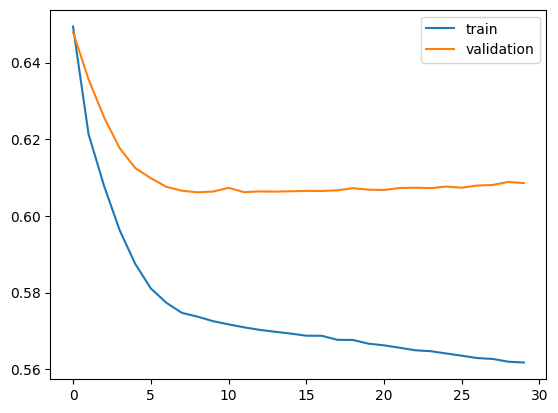

In [58]:
history = compile_and_fit(lstm_model, X_train_lstm, y_train_lstm, X_cal_lstm, y_cal_lstm, epochs = 30)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()

Evaluate

In [38]:
lagged_rows = TIME_STEPS-1
df_lstm = df.groupby('Team').apply(lambda group: group.iloc[lagged_rows:]).reset_index(level = 'Team', drop = True)
df_train_lstm = df_train.groupby('Team').apply(lambda group: group.iloc[lagged_rows:]).reset_index(level = 'Team', drop = True)
df_cal_lstm = df_cal.groupby('Team').apply(lambda group: group.iloc[lagged_rows:]).reset_index(level = 'Team', drop = True)
df_test_lstm = df_test.groupby('Team').apply(lambda group: group.iloc[lagged_rows:]).reset_index(level = 'Team', drop = True)

In [39]:
df_lstm['lstm_probas'] = lstm_model.predict(X_lstm)
df_train_lstm['lstm_probas'] = lstm_model.predict(X_train_lstm)
df_cal_lstm['lstm_probas'] = lstm_model.predict(X_cal_lstm)
df_test_lstm['lstm_probas'] = lstm_model.predict(X_test_lstm)

145/145 [==============================] - 0s 612us/step


2024-01-23 21:25:02.582533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-23 21:25:02.583651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-23 21:25:02.584513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 0s 724us/step


In [40]:
df_train_lstm['lstm_probas'].mean(), df_cal_lstm['lstm_probas'].mean(), df_test_lstm['lstm_probas'].mean()

(0.50000554, 0.5012036, 0.50011873)

Model Evaluation

In [41]:
from afl_match_outcome_model.evaluation.model_evaluation import ClassifierEvaluator

In [42]:
df_train_lstm['lstm_preds'] = np.where(df_train_lstm['lstm_probas'] > 0.5, 1, 0)
df_train_lstm['baseline'] = train_mean.mean()
df_train_lstm['baseline_label'] = np.where(df_train_lstm['Home'] < 0, 1, 0)

train_lstm_evals = ClassifierEvaluator(
    model=lstm_model,
    data=df_train_lstm,
    actual_name="Result",
    expected_name="lstm_probas",
    expected_label_name="lstm_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)

In [43]:
df_test_lstm['lstm_preds'] = np.where(df_test_lstm['lstm_probas'] > 0.5, 1, 0)
df_test_lstm['baseline'] = train_mean.mean()
df_test_lstm['baseline_label'] = np.where(df_test_lstm['Home'] < 0, 1, 0)

test_lstm_evals = ClassifierEvaluator(
    model=lstm_model,
    data=df_test_lstm,
    actual_name="Result",
    expected_name="lstm_probas",
    expected_label_name="lstm_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)


Model Averages

In [44]:
df_test_lstm[["Result", "lstm_preds", 'lstm_probas', "baseline_label", "baseline"]].describe()

,Result,lstm_preds,lstm_probas,baseline_label,baseline
count,258.000000,258.000000,258.000000,258.000000,258.000000
mean,0.500000,0.527132,0.500119,0.503876,0.114938
std,0.500972,0.500234,0.205982,0.500957,0.000000
min,0.000000,0.000000,0.149538,0.000000,0.114938
25%,0.000000,0.000000,0.321117,0.000000,0.114938
50%,0.500000,1.000000,0.512623,1.000000,0.114938
75%,1.000000,1.000000,0.673111,1.000000,0.114938
max,1.000000,1.000000,0.836922,1.000000,0.114938


Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [45]:
test_lstm_evals.get_log_loss()

Expected Log-Loss: 	0.6078
Compare Log-Loss: 	1.1427


(0.6078447978422643, 0.6078447978422643)

In [46]:
test_lstm_evals.get_brier_score_loss()

Expected Brier Score: 	0.2103
Compare Brier Score: 	0.3983


(0.21033704066026307, 0.3982728958194794)

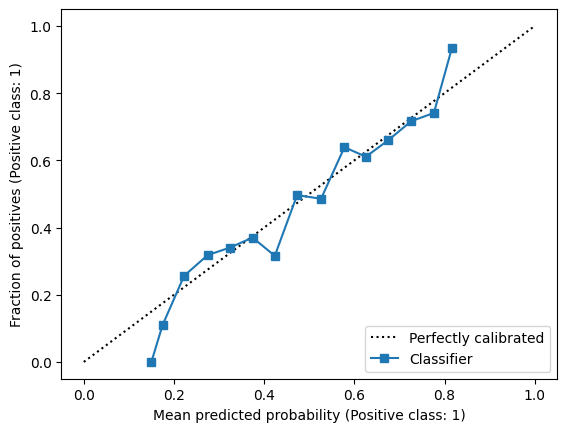

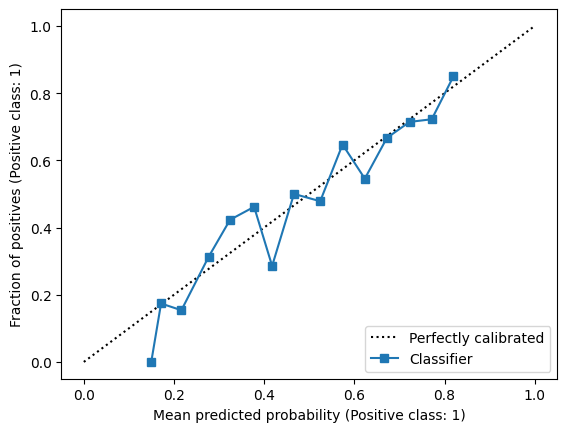

In [47]:
train_lstm_evals.display_calibration_curve(nbins=20)
test_lstm_evals.display_calibration_curve(nbins=20)

In [48]:
test_lstm_evals.get_accuracy(), test_lstm_evals.get_recall(), test_lstm_evals.get_precision(), test_lstm_evals.get_f1_score()

Expected Accuracy: 	0.6628
Compare Accuracy: 	0.4225
Expected Recall: 	0.6899
Compare Recall: 	0.4264
Expected Precision: 	0.6544
Compare Precision: 	0.4231
Expected F1 Score: 	0.6717
Compare F1 Score: 	0.4247


((0.6627906976744186, 0.42248062015503873),
 (0.689922480620155, 0.4263565891472868),
 (0.6544117647058824, 0.4230769230769231),
 (0.6716981132075471, 0.4247104247104247))

In [49]:
test_lstm_evals.get_confusion_matrix()

array([[82, 47],
       [40, 89]])

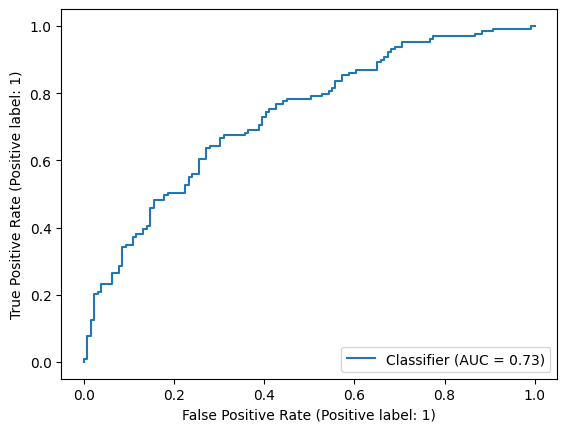

In [50]:
test_lstm_evals.plot_roc_curve()

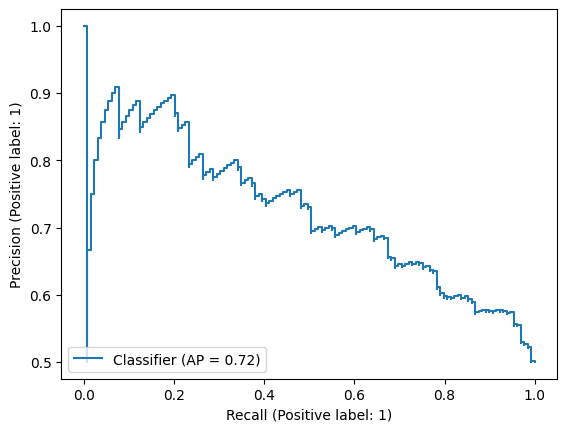

In [51]:
test_lstm_evals.plot_prauc_curve()

In [52]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3)                 108       
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 112
Trainable params: 112
Non-trainable params: 0
_________________________________________________________________


In [53]:
import shap
explainer = shap.KernelExplainer(lstm_model.predict, X_train_lstm)

91/91 [==============================] - 0s 631us/step


Using 2897 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [54]:
def f(X):
    return lstm_model.predict([X[:,i, :] for i in range(X.shape[1])]).flatten()

In [55]:
f(X_train_lstm)

ValueError: in user code:

    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 5)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=('tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)')
      • training=False
      • mask=None


In [ ]:
explainer = shap.KernelExplainer(f, X_train_lstm[:50,:, :])
shap_values = explainer.shap_values(X_train_lstm[299,:, :], nsamples=500)

Provided model function fails when applied to the provided data set.


ValueError: in user code:

    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/keras/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 5)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=('tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 5), dtype=float32)')
      • training=False
      • mask=None
